# The LRA generator class

This is a basic notebook to show how the LRA generator is built. Please note that this is a very memory and computing intensive operation and it is recommended to use the command line interface (CLI) - the `cli_lra_generator.py` for doing any of the following operations

In [1]:
from aqua import LRAgenerator

We set up some directory and folders, please change the outdir if you want to try this notebook!

In [10]:
model = 'IFS'
exp = 'tco1279-orca025'
source = 'ICMGG_atm2d'
outdir = '/scratch/b/b382076/test_lra/'

## A dry run
Initilize the class, and retrieve the data. We are asking to go to `r100` at monthly frequency. No data will be produed, but we check that everything is in place! Therefore we use `info` as loglevel to output all we need...

In [40]:
test = LRAgenerator(model=model, exp=exp, source=source, var='tprate', outdir=outdir,
                     resolution='r100', frequency='mon', loglevel='info')
test.retrieve()
test.generate_lra()

2023-05-01 11:33:36 :: lra_generator :: WARNING  -> IMPORTANT: no file will be created, this is a dry run
2023-05-01 11:33:36 :: lra_generator :: INFO     -> Variable(s) to be processed: tprate
2023-05-01 11:33:36 :: lra_generator :: INFO     -> Fixing data: True
2023-05-01 11:33:36 :: create_folder :: WARNING  -> Folder /scratch/b/b382076/test_lra/IFS/tco1279-orca025/r100/mon already exists
2023-05-01 11:33:36 :: lra_generator :: INFO     -> Accessing catalog for IFS-tco1279-orca025-ICMGG_atm2d...
2023-05-01 11:33:36 :: lra_generator :: INFO     -> I am going to produce LRA at r100 resolution and mon frequency...
2023-05-01 11:33:37 :: lra_generator :: WARNING  -> Retrieving data...
2023-05-01 11:33:39 :: Reader :: INFO     -> tprate: m --> m s**-1
2023-05-01 11:33:39 :: Reader :: INFO     -> tprate: corrected dividing by accumulation time 3600 s
2023-05-01 11:33:39 :: Reader :: INFO     -> Fixing tp to tprate. Unit fix: factor=0.000278, offset=0.000000
2023-05-01 11:33:39 :: Reader :

# A real run 

Initialize the LRA class, but setting `definitive` as true to create the actual data. Frequency is to `day` in this case

In [41]:
test = LRAgenerator(model=model, exp=exp, source=source, var='tprate', outdir=outdir,
                     resolution='r100', frequency='day', definitive=True)

2023-05-01 11:34:22 :: create_folder :: WARNING  -> Creating folder /scratch/b/b382076/test_lra/IFS/tco1279-orca025/r100/day


Retrieve the required data: they are stored in the `data` object

In [42]:
test.retrieve()
test.data

2023-05-01 11:34:25 :: lra_generator :: WARNING  -> Retrieving data...


<xarray.Dataset>
Dimensions:    (time: 17089, value: 6599680, plev: 5)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * plev       (plev) float64 500.0 400.0 300.0 200.0 100.0
    lon        (value) float64 dask.array<chunksize=(6599680,), meta=np.ndarray>
  * time       (time) datetime64[ns] 2020-01-20 ... 2022-01-01
Dimensions without coordinates: value
Data variables: (12/87)
    100si      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100u       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    100v       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10u        (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    10v        (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    2d         (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    ...         ...
    vike       (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vipie      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vipile     (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    vithe      (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    z          (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
    zos        (time, value) float64 dask.array<chunksize=(1, 6599680), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

Since this is a very intenstive operation, we do a hack and subselect the first month of the first year. The LRA loops on monthly data so that it can operate in a faster and less memory intensive way. We might want to move to OPA in the future, but so far simple `timmean` call are used

In [43]:
year = test.data.sel(time=test.data.time.dt.year == 2020)
month = year.sel(time=year.time.dt.month == 1)
test.data = month

Real run of the LRA, a couple of minutes to produce a monthly data for tprate

In [44]:
test.generate_lra()

2023-05-01 11:35:00 :: lra_generator :: WARNING  -> Generating LRA data...
2023-05-01 11:35:00 :: lra_generator :: WARNING  -> Processing variable tprate...
2023-05-01 11:35:00 :: lra_generator :: WARNING  -> Writing file /scratch/b/b382076/test_lra/IFS/tco1279-orca025/r100/day/tprate_tco1279-orca025_r100_day_202001.nc...


[########################################] | 100% Completed | 122.59 s


2023-05-01 11:37:03 :: lra_generator :: WARNING  -> Creating a single file for tprate, year 2020...
2023-05-01 11:37:03 :: lra_generator :: WARNING  -> Finished generating LRA data.


There is also an option to create an entry in the catalog (`.create_catalog_entry()`), but to avoid complication and to mess up with the original catalog this is not used here. To inspect the output produced, we just use xarray

In [48]:
import xarray as xr
file = xr.open_dataset('/scratch/b/b382076/test_lra/IFS/tco1279-orca025/r100/day/tprate_tco1279-orca025_r100_day_2020.nc')
file

<xarray.Dataset>
Dimensions:  (time: 12, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2020-01-31
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    tprate   (time, lat, lon) float64 ...

This can be plotted, showing daily values of precipitation

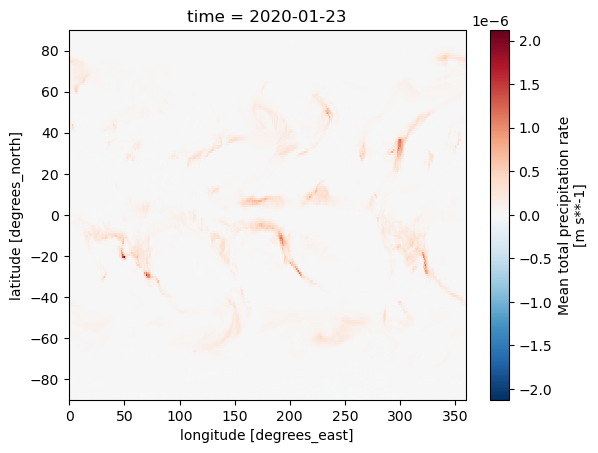

In [53]:
file['tprate'][3,:,:].plot()